In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from helper import plot_anomalies
from Dataset import DatasetLoader
from pyanomaly.stats import MAD, Tukey
from pyanomaly.timeseries import moving_average, moving_average_score, \
                                    twitter, twitter_score

In [2]:
loader = DatasetLoader()
#loader.print_all()

In [3]:
ds_names = loader.get_list('realKnownCause')
ds_names

['ambient_temperature_system_failure.csv',
 'cpu_utilization_asg_misconfiguration.csv',
 'ec2_request_latency_system_failure.csv',
 'machine_temperature_system_failure.csv',
 'nyc_taxi.csv',
 'rogue_agent_key_hold.csv',
 'rogue_agent_key_updown.csv']

## Preprocessamento

In [4]:
df_raw, labels = loader.load('machine_temperature_system_failure.csv')
df_raw.head()

,value
timestamp,
2013-12-02 21:15:00,73.967322
2013-12-02 21:20:00,74.935882
2013-12-02 21:25:00,76.124162
2013-12-02 21:30:00,78.140707
2013-12-02 21:35:00,79.329836


### Valores duplicados e missing data

In [5]:
df_raw.index.duplicated().sum()

12

In [6]:
df_raw[df_raw.index.duplicated()]

,value
timestamp,
2014-01-07 02:00:00,94.139723
2014-01-07 02:05:00,94.111970
2014-01-07 02:10:00,94.638723
2014-01-07 02:15:00,93.270907
2014-01-07 02:20:00,93.890249
2014-01-07 02:25:00,93.396627
2014-01-07 02:30:00,94.199300
2014-01-07 02:35:00,94.125420
2014-01-07 02:40:00,93.530827


In [7]:
df_raw['2014-01-07 02:00:00']

,value
timestamp,
2014-01-07 02:00:00,94.423406
2014-01-07 02:00:00,94.139723


In [8]:
df_raw.isnull().sum()

value    0
dtype: int64

In [9]:
df_raw.index.min(), df_raw.index.max(), df_raw.shape

(Timestamp('2013-12-02 21:15:00'),
 Timestamp('2014-02-19 15:25:00'),
 (22695, 1))

In [10]:
pd.date_range(start=df_raw.index.min(), end=df_raw.index.max(), freq='5T')

DatetimeIndex(['2013-12-02 21:15:00', '2013-12-02 21:20:00',
               '2013-12-02 21:25:00', '2013-12-02 21:30:00',
               '2013-12-02 21:35:00', '2013-12-02 21:40:00',
               '2013-12-02 21:45:00', '2013-12-02 21:50:00',
               '2013-12-02 21:55:00', '2013-12-02 22:00:00',
               ...
               '2014-02-19 14:40:00', '2014-02-19 14:45:00',
               '2014-02-19 14:50:00', '2014-02-19 14:55:00',
               '2014-02-19 15:00:00', '2014-02-19 15:05:00',
               '2014-02-19 15:10:00', '2014-02-19 15:15:00',
               '2014-02-19 15:20:00', '2014-02-19 15:25:00'],
              dtype='datetime64[ns]', length=22683, freq='5T')

In [11]:
df = df_raw[~df_raw.index.duplicated()]
df.head()

,value
timestamp,
2013-12-02 21:15:00,73.967322
2013-12-02 21:20:00,74.935882
2013-12-02 21:25:00,76.124162
2013-12-02 21:30:00,78.140707
2013-12-02 21:35:00,79.329836


In [12]:
df.shape

(22683, 1)

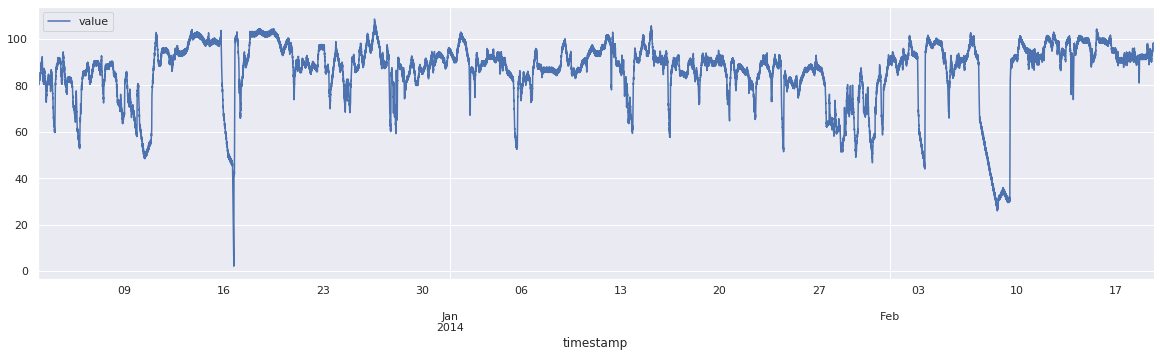

In [13]:
df.plot(figsize=(20, 5))

## Algoritmos

### MAD

In [22]:
mad = MAD()
mad.fit(df['value'])
madscore = mad.decision_function(df['value'])
madpredict = mad.predict(df['value'])
madscore.head()

timestamp
2013-12-02 21:15:00    1.962117
2013-12-02 21:20:00    1.839001
2013-12-02 21:25:00    1.687955
2013-12-02 21:30:00    1.431626
2013-12-02 21:35:00    1.280472
Name: value, dtype: float64

Text(0.5, 1.0, 'MAD score - Por ponto')

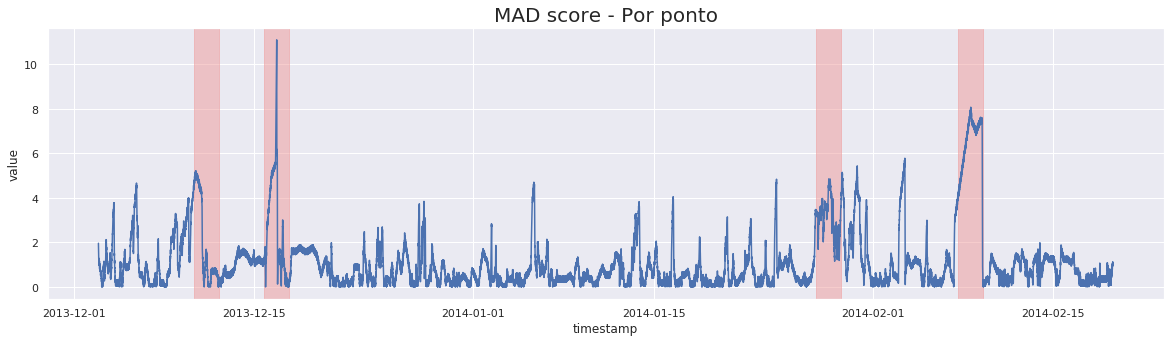

In [23]:
plot_anomalies(madscore, windows=labels)
plt.title("MAD score - Por ponto",fontsize=20)

Text(0.5, 1.0, 'MAD score - Média por Dia')

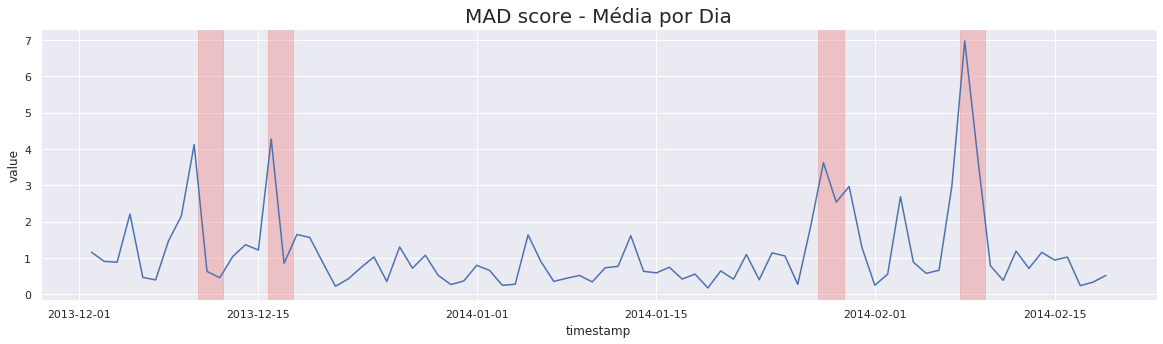

In [24]:
plot_anomalies(madscore.resample('1D').mean(), windows=labels)
plt.title("MAD score - Média por Dia",fontsize=20)

### Tukey

In [25]:
tu = Tukey()
tu.fit(df['value'])
tupredict = tu.predict(df['value'])
tupredict.head()

timestamp
2013-12-03 23:55:00    65.906496
2013-12-04 00:00:00    66.204651
2013-12-04 00:05:00    66.094398
2013-12-04 00:10:00    64.925151
2013-12-04 00:15:00    65.910542
Name: value, dtype: float64

Text(0.5, 1.0, 'Tukey score - Count 12H')

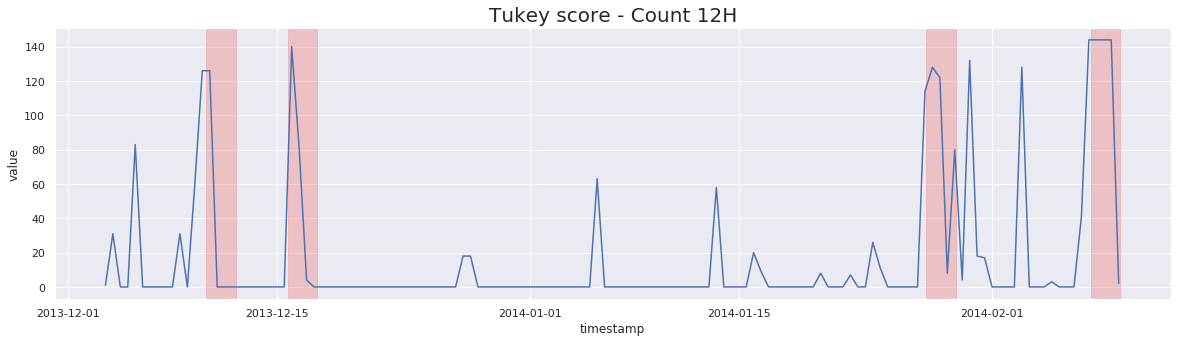

In [26]:
plot_anomalies(tupredict.resample('12H').count().dropna(), windows=labels)
plt.title("Tukey score - Count 12H",fontsize=20)

### Twitter

In [19]:
df_hour = df['value']#.resample('1H').mean().dropna()

twitterscore = twitter_score(df_hour, period=96)
twitterscore

timestamp
2013-12-02 21:15:00    1.945275
2013-12-02 21:20:00    1.841808
2013-12-02 21:25:00    1.700220
2013-12-02 21:30:00    1.439064
2013-12-02 21:35:00    1.300264
                         ...   
2014-02-19 15:05:00    1.159770
2014-02-19 15:10:00    1.112746
2014-02-19 15:15:00    1.028526
2014-02-19 15:20:00    1.165244
2014-02-19 15:25:00    0.978294
Length: 22683, dtype: float64

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


Text(0.5, 1.0, 'Twitter score - Média por hora')

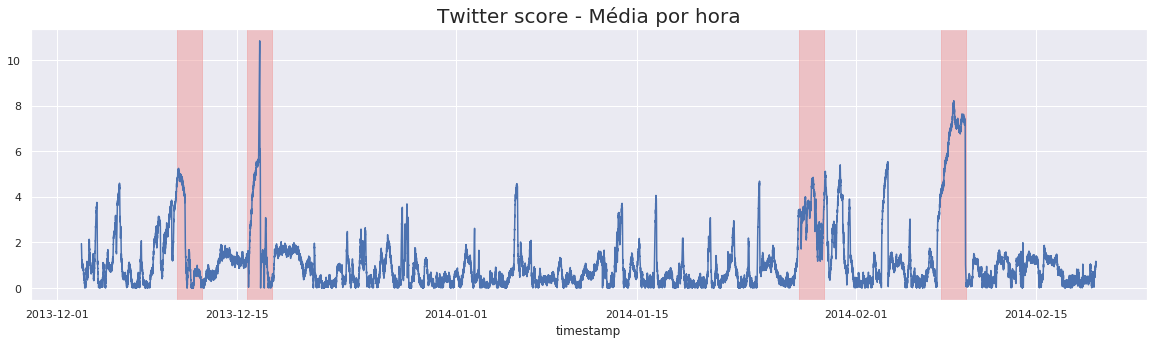

In [20]:
plot_anomalies(twitterscore, windows=labels)
plt.title("Twitter score - Média por hora", fontsize=20)

Text(0.5, 1.0, 'Twitter score - Média do Dia')

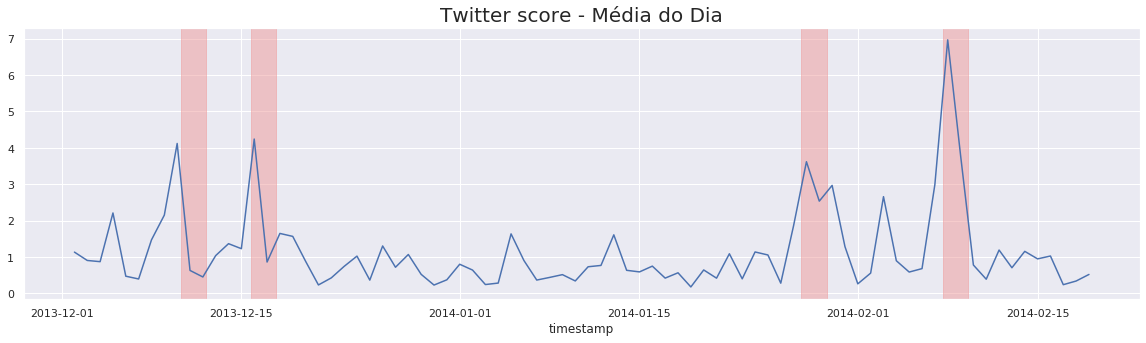

In [27]:
twitterday = twitterscore.resample('D').mean().dropna()

plot_anomalies(twitterday, windows=labels)
plt.title("Twitter score - Média do Dia",fontsize=20)

#### Analisando diferença entre MAD e Twitter

In [ ]:
from statsmodels.tsa.seasonal import STL

value = df['value'].resample('1H').mean().dropna()

x = STL(value)
res = x.fit()

In [ ]:
plt.rcParams['figure.figsize'] = 20, 10

res.plot()
res

In [ ]:
#plt.plot(value, color='red');
new_series = (value - res.seasonal - value.median())

plt.plot(new_series, color='black')
plt.title('Output do algoritmo para o MAD', fontsize=20);

In [ ]:
plt.plot(value - res.seasonal, color='black')
plt.plot(value, color='red');
plt.title('Comparação removendo o componente seasonal', fontsize=20)

### ARIMA/Holt-Winters

In [ ]:
#TODO

## Comparação por rank

In [31]:
from helper import top_k_precision, plot_precision_recall_curve

### Resample

In [39]:
# Resample os dados para Dia
madscore_day = madscore.resample('D').mean().dropna()
tuscore_day = tupredict.resample('D').count().dropna()
twitterscore_day = twitterscore.resample('D').mean().dropna()

In [40]:
# Calculando top k precision para cada tecnica
mad_topk = top_k_precision(madscore_day, labels, k=5)
tu_topk = top_k_precision(tuscore_day, labels, k=5)
twitter_topk = top_k_precision(twitterscore_day, labels, k=5)

df_topk = pd.DataFrame({'mad': mad_topk,
                        'tukey': tu_topk,
                        'twitter': twitter_topk},
                        index=np.arange(1, 6))
df_topk

[1. 1. 0. 0. 1.]
[1. 0. 1. 1. 0.]
[1. 1. 0. 0. 1.]


,mad,tukey,twitter
1,1.000000,1.000000,1.000000
2,1.000000,0.500000,1.000000
3,0.666667,0.666667,0.666667
4,0.500000,0.750000,0.500000
5,0.600000,0.600000,0.600000


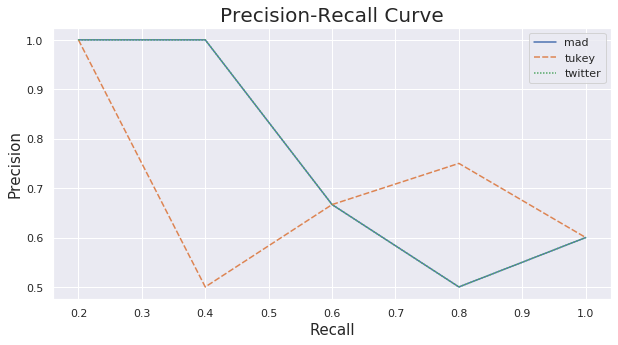

In [41]:
fig, ax = plot_precision_recall_curve(df_topk)

### Save

In [42]:
df_topk.index.names = ['rank']
df_topk.to_csv('./results/' + 'topk_score_' + ds_names[0])

In [43]:
fig.savefig('./results/' + 'topk_score_' + ds_names[0].split('.')[0] + '.jpg')